## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import arviz as az

%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
mpl.rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
mpl.rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
mpl.rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

## System parameters

In [4]:
# from exoplanet.eu catalog: https://exoplanet.eu/catalog/lp_714_47_b--7534/#publication_21546
# Dreizler et al 2020: https://www.aanda.org/articles/aa/full_html/2020/12/aa38016-20/aa38016-20.html

mass_pub = ufloat(0.0969, 0.0047)*u.M_jup.to(u.M_earth)
period_pub = ufloat(4.052037, 4e-06) # days
e_pub = ufloat(0.04, 0.02)
K_pub = ufloat(17.6, 0.8) # m/s
epoch_pub = ufloat(0.38421+58438, 0.00025)
radius_pub = ufloat(4.7, 0.3) # R_earth

stteff_pub = ufloat(3950, 51)
strad_pub = ufloat(0.584, 0.016)
stmass_pub = ufloat(0.59, 0.02)

## Read RVs

In [5]:
spirou = pd.read_table('./data/toi4438/lbl2_TOI4438_GL699_jun24.rdb', sep=None, engine='python', header=0)
carmenes = pd.read_table('./data/toi4438/carmenes_data/carmenes.rdb', sep=None, engine='python', header=0)

# substract 2400000 to the BJD time of carmenes
carmenes['rjd'] = carmenes['rjd'] - 2400000
rv_inst_names = ['spirou', 'carmenes']

star_name = 'TOI 4438'

In [6]:
spirou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Columns: 172 entries, rjd to svrad_2449nm
dtypes: float64(159), object(13)
memory usage: 87.5+ KB


In [7]:
# d2v is "differential line width", an activity indicator. 
# d3v is then the column linked to the third derivative, it is supposed to be linked to the asymmetry of the line, 
# but as far as I know no one tries to use that product yet
spirou.head()

,rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,local_file_name,plot_date,dW,...,vrad_2080nm,svrad_2080nm,vrad_2167nm,svrad_2167nm,vrad_2257nm,svrad_2257nm,vrad_2351nm,svrad_2351nm,vrad_2449nm,svrad_2449nm
0,59732.984348,-35123.282863,2.684813,1.043918e+06,6328.720826,2.403151e+07,1.088609e+07,2762023o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19145.475297,5.788712e+06,...,-35139.276131,7.601464,-35142.848891,12.843047,-35278.706195,19.611777,-35104.821769,15.491543,-35116.558072,20.264451
1,59734.020205,-35115.826332,2.745238,1.069501e+06,6457.594639,1.359737e+07,1.114657e+07,2762205o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19146.511146,5.930571e+06,...,-35121.989859,7.376265,-35132.543544,12.007437,-35199.380784,19.582315,-35078.673786,16.539267,-35143.804930,23.803596
2,59735.057384,-35112.464280,2.774137,1.015239e+06,6503.867083,6.135536e+06,1.125510e+07,2762381o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19147.548289,5.629680e+06,...,-35123.152654,7.596685,-35098.678961,12.524601,-35178.795053,20.275638,-35088.179654,16.662846,-35107.175059,24.196206
3,59735.989705,-35112.289597,2.964529,1.106869e+06,6888.458366,1.333161e+07,1.198604e+07,2762545o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19148.480591,6.137783e+06,...,-35125.376272,7.994345,-35094.420427,12.553439,-35177.306930,22.404775,-35086.701617,19.841099,-35091.842427,30.735095
4,59736.952200,-35111.584013,2.746853,1.065667e+06,6422.218951,1.455431e+07,1.112230e+07,2762718o_pp_e2dsff_tcorr_AB_TOI4438_GL699_lbl....,19149.443098,5.909314e+06,...,-35112.214136,7.194740,-35120.557407,11.992031,-35194.480320,19.176249,-35116.034145,15.870554,-35106.776137,22.023425


In [8]:
carmenes.head()

,rjd,vrad,svrad
0,59720.6490,1.90,3.99
1,59726.5607,-6.93,2.02
2,59730.5751,-1.11,2.20
3,59736.5664,2.74,1.81
4,59738.6403,-3.77,1.97


### Outliers

Text(0.5, 0, 'RV [km/s]')

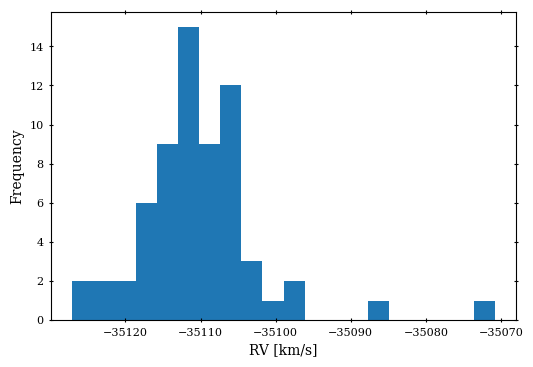

In [9]:
# histograma
spirou.vrad.plot(kind='hist', bins=20)
plt.xlabel('RV [km/s]')

<Axes: >

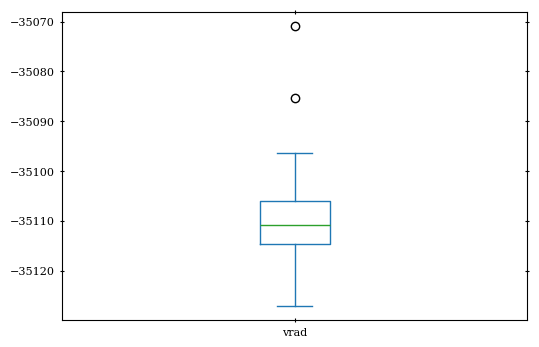

In [10]:
# boxplot
spirou.vrad.plot(kind='box')

In [11]:
# detect outliers using iqr
q1 = spirou.vrad.quantile(0.25)
q3 = spirou.vrad.quantile(0.75)
iqr = q3 - q1
mask = (spirou.vrad < (q1 - 1.5 * iqr)) | (spirou.vrad > (q3 + 1.5 * iqr))

# filter outliers
spirou = spirou[~mask]

# substract the mean of the radial velocity
spirou['vrad'] = spirou['vrad'] - spirou['vrad'].mean()

<Axes: >

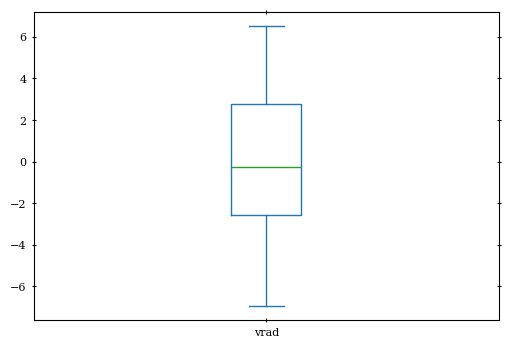

In [13]:
# after filtering
carmenes.vrad.plot(kind='box')

### Plot RVs

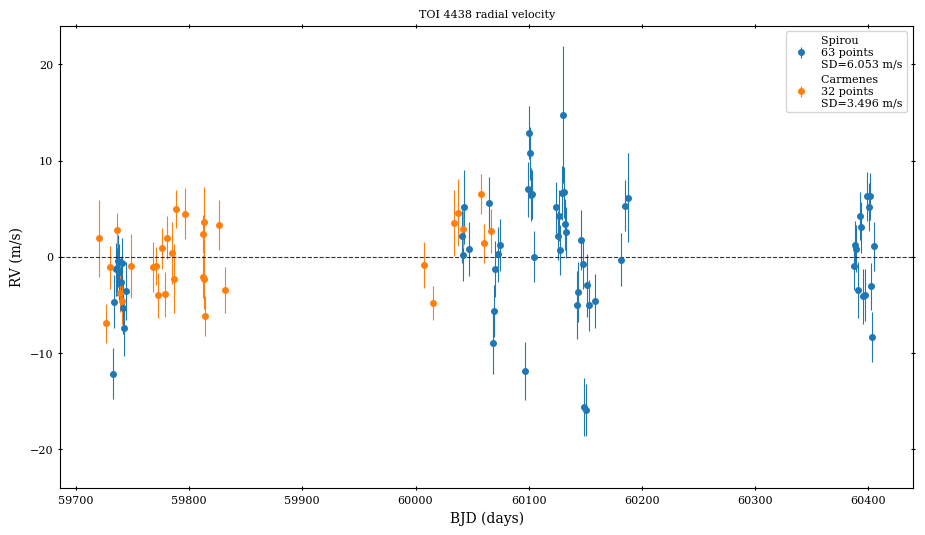

In [46]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.errorbar(spirou['rjd'], spirou['vrad'], yerr=spirou['svrad'], fmt='o', label=f'Spirou \n{len(spirou)} points\nSD={np.round(np.std(spirou.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C0')
ax.errorbar(carmenes['rjd'], carmenes['vrad'], yerr=carmenes['svrad'], fmt='o', label=f'Carmenes \n{len(carmenes)} points\nSD={np.round(np.std(carmenes.vrad),3)} m/s', markersize=4, elinewidth=0.8, color='C1')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.8)
ax.legend()
ax.set_title(f'{star_name} radial velocity')
ax.set_ylim(-24, 24)
ax.set_xlabel('BJD (days)')
ax.set_ylabel('RV (m/s)')
plt.show()

In [47]:
# prepare the data for the model
t_rv = np.concatenate((spirou['rjd'], carmenes['rjd']))
rv = np.concatenate((spirou['vrad'], carmenes['vrad']))
rv_err = np.concatenate((spirou['svrad'], carmenes['svrad']))
rv_inst_id = np.concatenate((np.zeros(len(spirou)), np.ones(len(carmenes))))

inds = np.argsort(t_rv)
t_rv = np.ascontiguousarray(t_rv[inds], dtype=np.float64)
rv = np.ascontiguousarray(rv[inds], dtype=np.float64)
rv_err = np.ascontiguousarray(rv_err[inds], dtype=np.float64)
rv_inst_id = np.ascontiguousarray(rv_inst_id[inds], dtype=int)

num_rv_inst = len(rv_inst_names)

### GLS analysis

In [197]:
series = ['spirou rvs', 'spirou dlw',  'carmenes rvs', 'all rvs', 'window function']

lg = [ls(spirou.rjd, spirou.vrad, spirou.svrad),
      ls(spirou.rjd, spirou.d2v, spirou.sd2v),
      ls(carmenes.rjd, carmenes.vrad, carmenes.svrad),
      ls(t_rv, rv, rv_err),
      ls(spirou.rjd, np.ones(len(spirou.rjd)), fit_mean=False, center_data=False)]

min_freq = 0.001
max_freq = 10
sppk = 5
probabilities = [0.1, 0.05, 0.01]

freq = {}
power = {}
fap = {}

for n, name in enumerate(series):
    freq[name], power[name] = lg[n].autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=sppk)
    if name != 'window function':
        fap[name] = lg[n].false_alarm_level(probabilities)

Text(0, 0.5, 'Power')

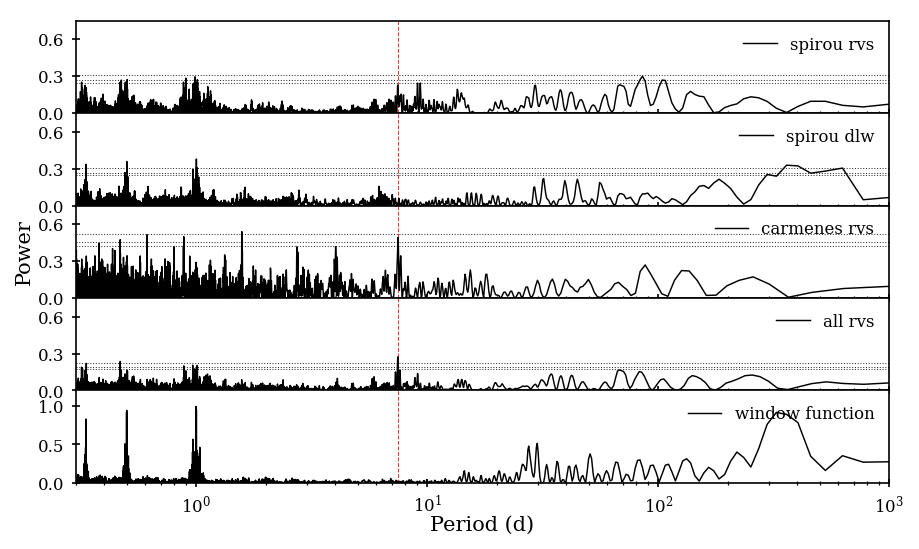

In [216]:
# plot the periodograms
fig, ax = plt.subplots(len(series), 1, sharex=True, figsize=(7,4), dpi=150)
#fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

for i, name in enumerate(series):
    ax[i].axvline(x=period_tess.nominal_value, color='r', linestyle='--', linewidth=0.5, alpha=0.8)
    ax[i].plot(1/freq[series[i]], power[series[i]], color='k', linewidth=0.7, label=name)
    ax[i].set_ylabel(series[i])
    ax[i].set_ylim(0, 0.75)
    ax[i].set_xlim(0.3, 1000)
    ax[i].set_xscale('log')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend(frameon=False, markerscale=0, loc='upper right')
    ax[i].set_yticks([0.0, 0.3, 0.6])
    ax[i].tick_params(which='both', top=False, right=False)
    if name == "window function":
        ax[i].set_ylim(0, 1.2)
        ax[i].set_yticks([0.0, 0.5, 1.0])
    else:
        ax[i].axhline(y=fap[name][0], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                  , label=f'FAP {probabilities[0]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][1], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[1]*100}%', zorder=0)
        ax[i].axhline(y=fap[name][2], color='k', linestyle=':', linewidth=0.5, alpha=0.8
                    , label=f'FAP {probabilities[2]*100}%', zorder=0)
    
# add a big axis, hide frame
bigax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
bigax.set_xlabel("Period (d)", labelpad=2)
bigax.set_ylabel("Power", labelpad=2)

## Read LCs

In [ ]:
#exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480

In [55]:
lk.search_targetpixelfile('TIC 22233480')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 79,2024,SPOC,120,22233480,0.0
5,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
6,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0
7,TESS Sector 53,2022,TESS-SPOC,600,22233480,0.0


In [120]:
search = lk.search_lightcurve('TIC 22233480')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,SPOC,120,22233480,0.0
1,TESS Sector 52,2022,SPOC,120,22233480,0.0
2,TESS Sector 53,2022,SPOC,120,22233480,0.0
3,TESS Sector 79,2024,SPOC,20,22233480,0.0
4,TESS Sector 79,2024,SPOC,120,22233480,0.0
5,TESS Sector 40,2021,TESS-SPOC,600,22233480,0.0
6,TESS Sector 52,2022,TESS-SPOC,600,22233480,0.0
7,TESS Sector 53,2022,TESS-SPOC,600,22233480,0.0
8,TESS Sector 40,2021,QLP,600,22233480,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

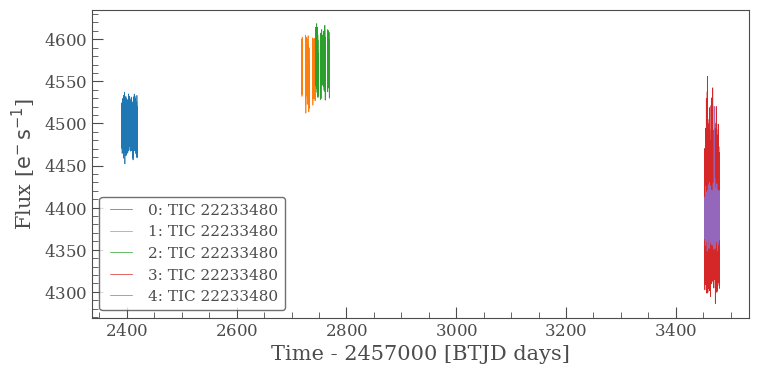

In [127]:
search[search.author == 'SPOC'].download_all().plot()

In [185]:
lc_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', exptime=120, sector=[40, 52, 53]).download_all(flux_column="pdcsap_flux")
lc_79_fast_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79], exptime=20).download_all(flux_column="pdcsap_flux")
lc_79_short_file = lk.search_lightcurve('TIC 22233480', author='SPOC', sector=[79], exptime=120).download_all(flux_column="pdcsap_flux")

lc_short = lc_short_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_fast = lc_79_fast_file.stitch().remove_nans().normalize().remove_outliers()
lc_79_fast_bin = lc_79_fast.bin(time_bin_size=120*u.s.to(u.day))
lc_79_short = lc_79_short_file.stitch().remove_nans().normalize().remove_outliers()

(-0.5, 0.5)

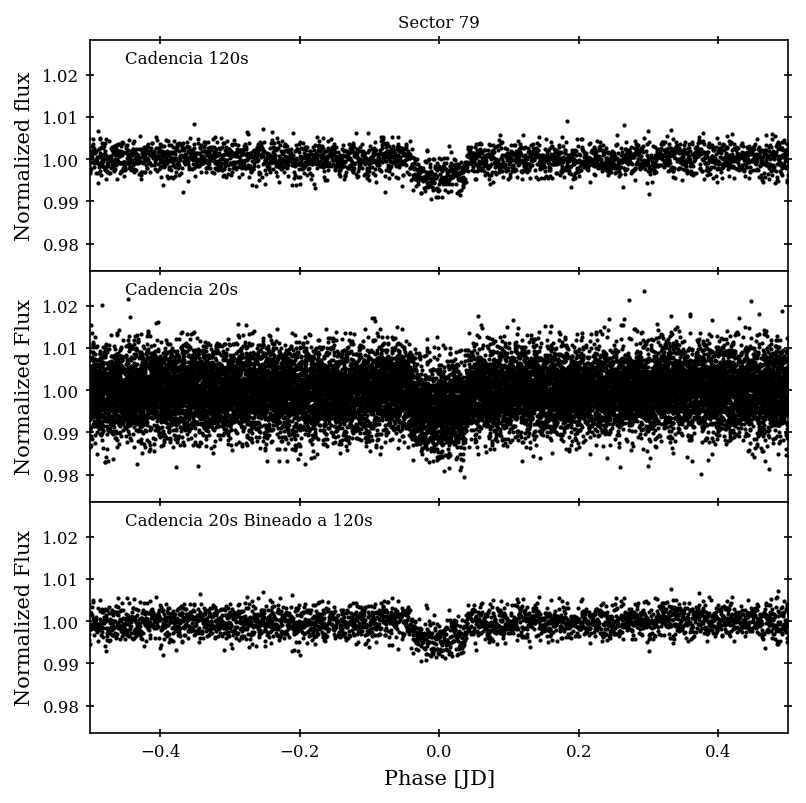

In [181]:
# sector 79
fig, ax = plt.subplots(3, 1, figsize=(6,6), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
lc_79_short.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[0], c='k', label='')
lc_79_fast.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[1], c='k', label='')
lc_79_fast_bin.fold(period=period_tess.nominal_value, epoch_time=epoch_tess.nominal_value-2457000).scatter(ax=ax[2], c='k', label='')
ax[0].text(0.05, 0.9, 'Cadencia 120s', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'Cadencia 20s', transform=ax[1].transAxes)
ax[2].text(0.05, 0.9, 'Cadencia 20s Bineado a 120s', transform=ax[2].transAxes)
ax[0].set_title('Sector 79')
ax[0].set_ylabel('Normalized flux')
ax[0].set_xlabel('Phase')
plt.xlim(-0.5, 0.5)
#plt.savefig('lc_79.png', dpi=300)

In [193]:
# for the model, short and fast cadence are concatenated
time = np.concatenate((lc_short.time.value, lc_79_fast.time.value))
flux = np.concatenate((lc_short.flux.value, lc_79_fast.flux.value))
flux_err = np.concatenate((lc_short.flux_err.value, lc_79_fast.flux_err.value))
lc_cadence = np.concatenate((np.zeros(len(lc_short.time.value)), np.ones(len(lc_79_fast.time.value))))
inds2 = np.argsort(time)
time = np.ascontiguousarray(time[inds2], dtype=np.float64)
flux = np.ascontiguousarray(flux[inds2], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[inds2], dtype=np.float64)
lc_cadence = np.ascontiguousarray(lc_cadence[inds2], dtype=int)
cadences = ['120s', '20s']
num_lc_cadence = len(cadences)

# for faster computation, sector 79 binned to 120s
time_fast = lc_79_fast_bin.time.value
flux_fast = lc_79_fast_bin.flux.value
flux_err_fast = lc_79_fast_bin.flux_err.value

# get the exptimes
with fits.open(lc_short_file[0].filename) as hdu:
    hdr = hdu[1].header
with fits.open(lc_79_fast_file[0].filename) as hdu:
    hdr_79 = hdu[1].header

texp_short = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp_short /= 60.0 * 60.0 * 24.0
texp_79 = hdr_79["FRAMETIM"] * hdr_79["NUM_FRM"]
texp_79 /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr = np.ascontiguousarray(1e3 * flux_err, dtype=np.float64) 

### TLS en sector 79

In [194]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

In [ ]:
# model

# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t_rv = dict()
phase_lc = np.linspace(-0.15, 0.15, 500)

for k, data in enumerate(datasets):
    t_rv[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        logP = pm.Normal("logP", mu=np.log(bls_period), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
        P = pm.Deterministic("P", tt.exp(logP))
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)

        # logK = pm.Normal("logK", mu=np.log(Kest[k].item()), sd=2.0, testval=np.log(Kest[k].item()))
        # K = pm.Deterministic("K", tt.exp(logK))
        K = pm.Uniform("K", lower=0, upper=10)

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit         
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth*1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * rstar)
        b = xo.ImpactParameter('b', ror)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar,
                                        b=b)

        # derive mass, semimajor axis, and equilibrium temperature, and denisty
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))
        density_pl = pm.Deterministic('density_pl', m_pl*u.kg.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))
        teq = pm.Deterministic('teq', stteff_tess.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))

        # The light curve model
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)
        logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=1)

        def lc_model(mean, star, r_pl, texp, t):
            return pm.Deterministic("lc_model_", tt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean)
        
        lc_model_ = lc_model(mean, star, r_pl, texp, x)
        # The likelihood for the light curve
        err_lc = tt.sqrt(yerr**2 + tt.exp(2*logs)) 
        transit_obs = pm.Normal("lc_obs", mu=lc_model_, sd=err_lc, observed=y) 

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred", tt.sum(star.get_light_curve(orbit=orbit, r=r_pl, t=t0+phase_lc, texp=texp)*1e3, axis=-1))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t_rv[k], name="_pred")

        # Finally add in the RV observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])